# Covid-19 infección en Ecuador. Modelos probabilisticos
Implementacion de un modelo probabilistico de infección por el virus Covid-19

Se realiza un análisis probabilistico simple del crecimiento de la infección en Python y el modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de probabilidad.

In [50]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression 

%matplotlib inline


In [41]:
# Actualizar los datos (URL)
url = 'https://covid.ourworldindata.org/data/ecdc/new_cases.csv'
df = pd.read_csv(url)
df

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,2019-12-31,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,2020-01-01,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,2020-01-02,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,2020-01-03,17,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,2020-01-04,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2020-04-20,74142,88.0,14.0,94.0,9.0,0.0,0.0,0.0,102.0,...,24601,0.0,11.0,70.0,0.0,29.0,0.0,0.0,4.0,0.0
112,2020-04-21,77274,35.0,22.0,89.0,4.0,0.0,0.0,0.0,90.0,...,28065,1.0,7.0,92.0,1.0,0.0,0.0,0.0,4.0,0.0
113,2020-04-22,87387,61.0,25.0,93.0,0.0,0.0,0.0,1.0,112.0,...,37289,0.0,8.0,35.0,0.0,29.0,0.0,0.0,0.0,3.0
114,2020-04-23,67629,84.0,25.0,99.0,6.0,0.0,0.0,0.0,144.0,...,17588,0.0,6.0,24.0,0.0,3.0,0.0,0.0,9.0,0.0


Imprimos los resultados y agregamos el numero del dia


In [42]:
df = df.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df

,date,Ecuador
0,-1,0.0
1,0,0.0
2,1,0.0
3,2,0.0
4,3,0.0
...,...,...
111,110,446.0
112,111,660.0
113,112,270.0
114,113,452.0


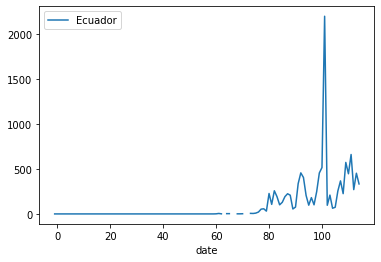

In [43]:
df.plot(x ='date', y='Ecuador')

Ahora podemos analizar un modelo probabilisto para el examen.

## El modelo basado en probabilidad

Para realizar un estimacion del factor de crecimiento de los casos de Covid 19 en Ecuador calculamos la mediana, con esto obtenemo el valor medio de crecimiento de un conjunto de datos, con esto podemos obtener un factor de crecimiento o taza de crecimiento de los nuevos casos.



In [44]:
filtro = df["Ecuador"][61:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
print(mediana)
print(media)

155.0
223.66


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [45]:
#Vamos a comprobar:
# según la media y la mediana podemos obtener la taza de crecieminto y predicir su comportamiento.
# Cargamos los datos de total de casos
url = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df_t = pd.read_csv(url)
FMT = '%Y-%m-%d'
date = df_t['date']
df_t['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df_t = df_t.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
y = list(df_t.iloc [:, 1]) # Total casos
x = list(df_t.iloc [:, 0]) # Dias
#Realizamos un ejemplo de prediccion
prediccion_siguiente = int(y[-1] + mediana)
print(prediccion_siguiente)

11338


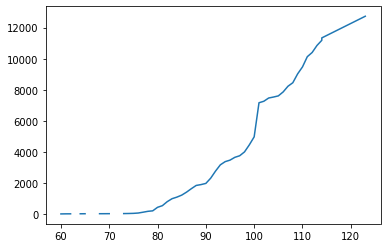

In [46]:
# Quiero predecir cuántos "Casos" voy a obtener de aqui a 10 dias.
for i in range(x[-1], x[-1]+10):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x[61:], y[61:])
plt.show()

# Practica

1. Comparar el modelo de predicion matematico vs probabilidad.
2. Generar el SIR en base al modelo de probabilidad y obtener beta y gamma con una semana de prediccion.
3. Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

Puntos extras: Investigas sobre la correlacion de variables y aplicar el calculo en base a los datos del Ecuador.

In [91]:
#Implementar
url1 = 'https://covid.ourworldindata.org/data/ecdc/new_cases.csv'
df1 = pd.read_csv(url1)
df1

df1 = df1[df1['Ecuador'] != 0.0 ]
df1 = df1[ ~np.isnan(df1['Ecuador'])]
df1 = df1.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis

FMT = '%Y-%m-%d'
date = df1['date']
df1['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)

url2 = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df2 = pd.read_csv(url2)
df2

df2 = df2[df2['Ecuador'] != 0.0 ]
df2 = df2[ ~np.isnan(df2['Ecuador'])]
df2 = df2.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis

# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df2['date']
df2['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
print(len(df1))
print(len(df2))

50
50


In [122]:
filtro = df1["Ecuador"][:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
print('Mediana: ',mediana)
print('Media: ',media)

Mediana:  155.0
Media:  223.66


11338


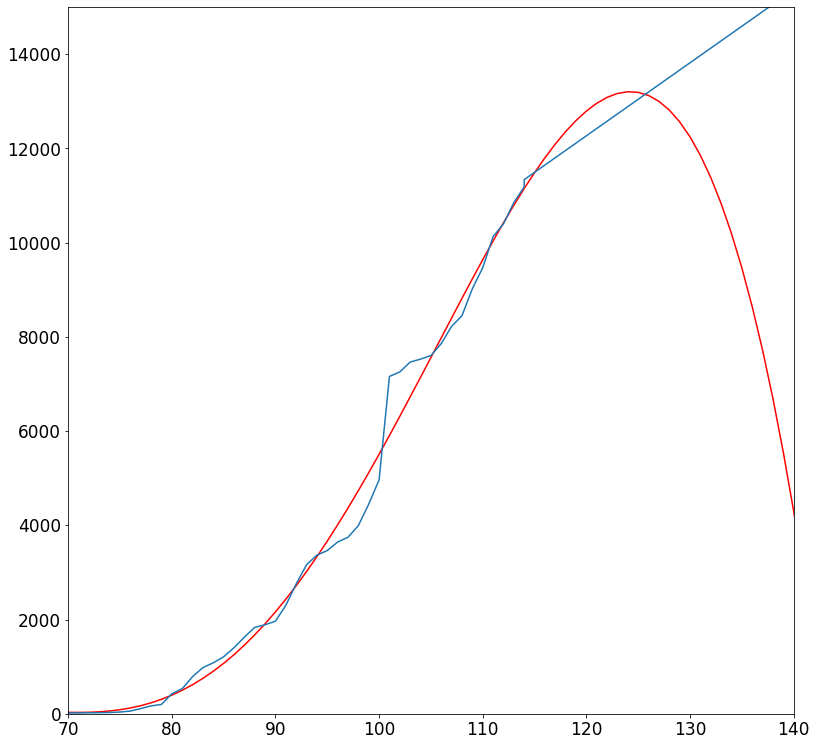

In [123]:
y = list(df2.iloc [:, 1]) # Total casos
x = list(df2.iloc [:, 0]) # Dias

pf = PolynomialFeatures(degree = 4)    # usaremos polinomios de grado 5
X = pf.fit_transform(np.array(x).reshape(-1, 1))

regresion_lineal = LinearRegression()

regresion_lineal.fit(X, y) 

pred_x = list(range(0,max(x)+60))

JM = pf.fit_transform(np.array(pred_x).reshape(-1, 1))

prediccion_entrenamiento = regresion_lineal.predict(JM)

plt.plot(JM, prediccion_entrenamiento, color='red')

#Realizamos un ejemplo de prediccion
prediccion_siguiente = int(y[-1] + mediana)
print(prediccion_siguiente)

for i in range(x[-1], x[-1]+30):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x, y)

plt.ylim(0,15000)
plt.xlim(70,140)

plt.show()

# Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales

In [94]:
df1_7 = df1[:len(df1)-7]
df2_7 = df2[:len(df2)-7]

filtro = df1_7["Ecuador"][:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
print('Mediana: ',mediana)
print('Media: ',media)

Mediana:  101.0
Media:  191.27906976744185


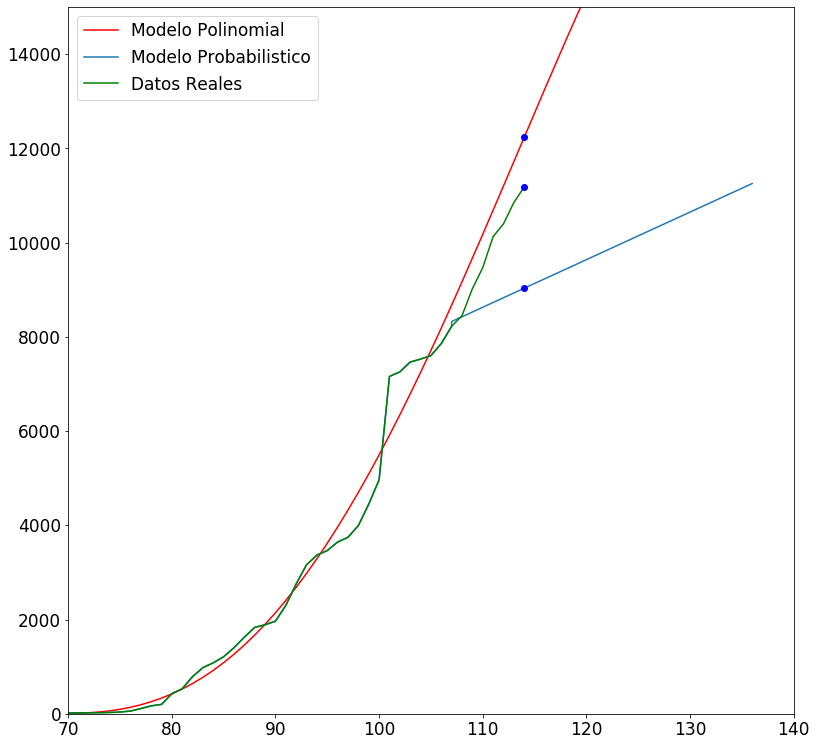

Modelo polinomial:  12236.154734535667
Datos Reales:  11183.0
Modelo Probabilistico 9033


In [120]:
y_7 = list(df2_7.iloc [:, 1]) # Total casos
x_7 = list(df2_7.iloc [:, 0]) # Dias
y = list(df2.iloc [:, 1]) # Total casos
x = list(df2.iloc [:, 0]) # Dias

pf = PolynomialFeatures(degree = 4)    # usaremos polinomios de grado 4
X = pf.fit_transform(np.array(x_7).reshape(-1, 1))

regresion_lineal = LinearRegression()

regresion_lineal.fit(X, y_7) 

pred_x = list(range(0,max(x_7)+60))

JM = pf.fit_transform(np.array(pred_x).reshape(-1, 1))

prediccion_entrenamiento = regresion_lineal.predict(JM)

plt.rcParams['figure.figsize'] = [13, 13]
plt.rc('font', size=17)

plt.plot(pred_x, prediccion_entrenamiento,label='Modelo Polinomial', color='red')

#Realizamos un ejemplo de prediccion
prediccion_siguiente = int(y_7[-1] + mediana)


for i in range(x_7[-1], x_7[-1]+30):
    x_7.append(i)
    y_7.append(int(y_7[-1] + mediana))
plt.plot(x_7, y_7, label='Modelo Probabilistico')
plt.plot(x, y,label='Datos Reales' ,color='green')

plt.plot(x[-1],prediccion_entrenamiento[x[-1]],'ob')
plt.plot(x[-1],y[-1],'ob')
plt.plot(x[-1],y_7[len(x)],'ob')

plt.legend()
plt.ylim(0,15000)
plt.xlim(70,140)
plt.show()
print("Modelo polinomial: ",prediccion_entrenamiento[x[-1]])
print("Datos Reales: ",y[-1])
print("Modelo Probabilistico",y_7[len(x)])

## Analisis
Al realizar la la comparación entre los valores reales, los valores que nos devuelve el metodo matematico y probabilistico, se puede ver que la predicción polinomial de grado 4 se aproxima mas a los datos reales.

## Conclusiones
en una situación de contagio me acopla mas el modelo polinomial a los datos reales, sin embargo se puede notar que los datos tedichos tienen un grado de certesa poco acertado a los reales. Esto se puede deber a la irreguraridad de los datos y la mala practica en la toma de dichos datos.

## Criterio personal (politico, economico y  social de la situacion)



# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/